## Author: Vikas Raunak, Vivek Gupta, Florian Metze

In [1]:
import sys
import os

from operator import itemgetter
from collections import Counter

import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
"""
file = 'glove.6B.300d.txt'

glove = {}
with open(file, 'r', encoding='UTF8') as f:
    print("Loading Glove vectors.")
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        glove[word] = vector
    print('Done.')
            
words = list(glove.keys())
vectors = np.asarray([glove[word] for word in words])
"""

'\nfile = \'glove.6B.300d.txt\'\n\nglove = {}\nwith open(file, \'r\', encoding=\'UTF8\') as f:\n    print("Loading Glove vectors.")\n    for line in f:\n        values = line.split()\n        word = values[0]\n        vector = np.asarray(values[1:], \'float32\')\n        glove[word] = vector\n    print(\'Done.\')\n            \nwords = list(glove.keys())\nvectors = np.asarray([glove[word] for word in words])\n'

**BASELINE FUNCTIONS**

In [3]:
def PPA(X, D, n):
    # Subtract Mean Embedding
    X = np.array(X-np.mean(X)) 
    
    # Compute PCA Components
    pca = PCA(n_components=D)
    transformed_X = pca.fit_transform(X)
    
    # Remove Top-D Components
    remove_dominance_X = []    
    for i, v in enumerate(X):
        for u in pca.components_[0:n]:
            v = v - np.dot(u.T, v) * u
        remove_dominance_X.append(v)
        
    return np.asarray(remove_dominance_X)

In [8]:
def base_pca(file, N): # X is a word vector, N is a dimension want to reduction
    glove = {}
    with open(file, 'r', encoding='UTF8') as f:
        print("Loading Glove vectors.")
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            glove[word] = vector
        print('Done.')
            
    words = list(glove.keys())
    vectors = np.asarray([glove[word] for word in words])
    
    for dim in N:
        p_emb = {}
        emb_file = open('base_pca_emb_%d.txt' % dim, 'w', encoding='UTF8')

        # PCA
        X = vectors - np.mean(vectors)
        p = PCA(n_components=dim)
        reduced_X = p.fit_transform(X)

        for i,v in enumerate(words):
            p_emb[v] = reduced_X[i]
            emb_file.write('%s\t' % v)
            for t in p_emb[v]:
                emb_file.write('%f\t' % t)
            emb_file.write('\n')

        return p_emb, p.explained_variance_ratio_

def base_ppa_pca(file, N, D, n):
    # Load pre-trained glove 300d file
    glove = {}
    with open(file, 'r', encoding='UTF8') as f:
        print("Loading Glove vectors.")
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            glove[word] = vector
        print('Done.')
    
    # Change into words list and word vectors
    words = list(glove.keys())
    vectors = np.asarray([glove[word] for word in words])
    
    for dim in N:
        # Empty Dict and text file
        p_emb = {}
        emb_file = open('base_ppa_pca_emb_%d.txt' % dim, 'w', encoding='UTF8')

        # PPA
        new_X = PPA(vectors, D, n)
        new_X = new_X - np.mean(new_X)

        # PCA
        p = PCA(n_components=dim)
        reduced_X = p.fit_transform(new_X)

        # Make Dictioary and text file
        for i,v in enumerate(words):
            p_emb[v] = reduced_X[i]
            emb_file.write('%s\t' % v)
            for t in p_emb[v]:
                emb_file.write('%f\t' % t)
            emb_file.write('\n')

        return p_emb, p.explained_variance_ratio_

def base_pca_ppa(file, N, n):
    glove = {}
    with open(file, 'r', encoding='UTF8') as f:
        print("Loading Glove vectors.")
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            glove[word] = vector
        print('Done.')
            
    words = list(glove.keys())
    vectors = np.asarray([glove[word] for word in words])
    
    for dim in N:
        p_emb = {}
        emb_file = open('base_pca_ppa_emb_%d.txt' % dim, 'w', encoding='UTF8')

        # PCA
        X = vectors - np.mean(vectors)
        p = PCA(n_components=dim)
        new_X = p.fit_transform(X)

        # PPA
        reduced_X = new_X - np.mean(new_X)
        p = PCA(n_components=dim)
        second_reduced_X = p.fit_transform(reduced_X)

        final_X = new_X - np.mean(new_X) 
        for i,v in enumerate(words):
            p_emb[v] = final_X[i]
            emb_file.write('%s\t' % v)
            for u in p.components_[0:n]:
                p_emb[v] = p_emb[v] - np.dot(u.transpose(), p_emb[v]) * u

            for t in p_emb[v]:
                emb_file.write('%f\t' % t)

            emb_file.write('\n')

        return p_emb, p.explained_variance_ratio_

In [5]:
def r_vectors(file):
    vecs = {}
    
    file = open(file, 'r', encoding='UTF8')        
    for _, line in enumerate(file):
        line = line.strip().lower()
        word = line.split()[0]
        v = line.split()[1:]
        vecs[word] = np.zeros(len(line.split())-1, dtype=float)
        for i, val in enumerate(v):
            vecs[word][i] = val
        vecs[word] /= math.sqrt((vecs[word]**2).sum() + 1e-6)
        
    return vecs

In [6]:
def cosine_sim(vec1, vec2):
    vec1 += 1e-6 * np.ones(len(vec1))
    vec2 += 1e-6 * np.ones(len(vec2))
    return vec1.dot(vec2) / np.linalg.norm(vec1)*np.linalg.norm(vec2)

def ranking_wvecs(dictionary):
    rank = {}
    list = [(k, v) for (k, v) in sorted(dictionary.items(), key=itemgetter(1), reverse=True)]
    
    for i, (k1, v1) in enumerate(list):
        same = []
        for j, (k2, v2) in enumerate(list):
            if v1 == v2:
                same.append(j+1)
        if len(same) == 1:
            rank[k1] = i+1
        else:
            rank[k1] = 1.0 * np.sum(same) / len(same)
    
    return rank

def rho_spearmans(dict1, dict2):
    assert len(dict1) == len(dict2)
    
    if len(dict1) == 0 or len(dict2) == 0: 
        return 0
    
    dict1_avg = 1.0 * np.sum([val for val in dict1.values()]) / len(dict1)
    dict2_avg = 1.0 * np.sum([val for val in dict2.values()]) / len(dict2)
    num, x, y = (0, 0, 0)
    
    for k in dict1.keys():
        x_i = dict1[k]
        y_i = dict2[k]
        num += (x_i - dict1_avg)*(y_i - dict2_avg)
        x += (x_i - dict1_avg) ** 2
        y += (y_i - dict2_avg) ** 2
        
    return (num / math.sqrt(x*y)) * 100 

In [7]:
def Algo_N(file, N, D, n):
    embeddings = {}
    with open(file, 'r', encoding='UTF8') as f:
        print("Loading word vectors.")
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            embeddings[word] = vector
        print('Done.')
            
    words = list(embeddings.keys())
    vectors = np.asarray([embeddings[word] for word in words])
    
    for dim in N:
        p_emb = {}
        emb_file = open('algo_%d_%s.txt' %(dim, file), 'w', encoding='UTF8')

        # PPA
        X = PPA(vectors, D, n)

        # PCA
        X = X - np.mean(X)    
        p = PCA(n_components=dim)
        new_X = p.fit_transform(X)

        # PPA
        final_X = new_X - np.mean(new_X)
        p = PCA(n_components=dim)
        reduced_X = p.fit_transform(final_X)

        print("Make Algo_%d text file" % dim)
        for i,v in enumerate(words):
            p_emb[v] = final_X[i]
            emb_file.write('%s\t' % v)
            for u in p.components_[0:n]:
                p_emb[v] = p_emb[v] - np.dot(u.transpose(), p_emb[v]) * u

            for t in p_emb[v]:
                emb_file.write('%f\t' % t)

            emb_file.write('\n')
        print("Done.")

## Section 2 Proposed Algorithm

### 2.1 Post-Processing Algorithm

**Original Glove-300D**
* 300D $\rightarrow$ PCA-20D

**After Post-Processing**
* 300D $\rightarrow$ PPA(D=7)-300D $\rightarrow$ PCA-20D

In [8]:
# file = 'glove.6B.300d.txt'
# pca_origin, var1 = base_pca(file, [20])
# ppa_pca, var2 = base_ppa_pca(file, [20], 300, 7)

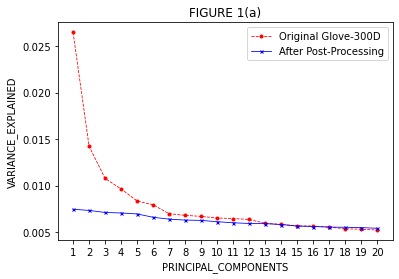

In [9]:
plt.plot(var1, marker='o', c='r',
         linestyle='--', markersize=3, linewidth=0.8, label='Original Glove-300D')
plt.plot(var2, marker='x', c='b', 
         markersize=3,linewidth=0.8, label='After Post-Processing')
plt.title("FIGURE 1(a)")
plt.xlabel('PRINCIPAL_COMPONENTS')
plt.ylabel('VARIANCE_EXPLAINED')
plt.xticks(np.arange(len(var1)), np.arange(1, len(var1)+1))
plt.legend()
plt.show()

### 2.2 Proposed Algorithm

**Post-Processing + PCA-150D**
* 300D $\rightarrow$ PPA(D=7)-300D $\rightarrow$ PCA-150D

**After Further Post-Processing**
* 300D $\rightarrow$ PPA(D=7)-300D $\rightarrow$ PCA-150D $\rightarrow$ PPA(D=7)-150D

In [9]:
def Dim_Reduct_Algo(X, N, D, n, further_processing=False):    
    # Apply Algorithm 1 (PPA)
    X = PPA(X, D, n)
    
    # Transform X using PCA
    pca = PCA(n_components=N)
    new_X = X - np.mean(X)
    ppa_pca_X = pca.fit_transform(new_X)
    
    # Apply Algorithm 1 (PPA)
    if further_processing == True:
        D = len(pca.components_)
        ppa_pca_ppa_X = PPA(ppa_pca_X, D, n)
        return ppa_pca_ppa_X
    
    return ppa_pca_X

In [11]:
X = np.array([glove[word] for word in words])

pp_p150d = Dim_Reduct_Algo(X, 150, 300, 7)
pp_p150d_pp = Dim_Reduct_Algo(X, 150, 300, 7, further_processing=True)

In [12]:
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=20)

pp_p150d_p20d = pca_1.fit_transform(pp_p150d)
pp_p150d_pp_p20d = pca_2.fit_transform(pp_p150d_pp)

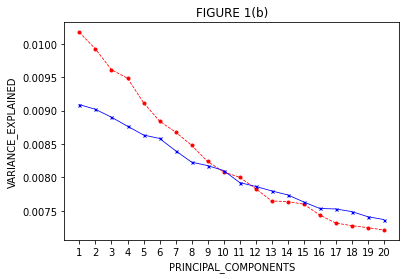

In [13]:
plt.plot(pca_1.explained_variance_ratio_, marker='o', c='r', linestyle='--', markersize=3, linewidth=0.8)
plt.plot(pca_2.explained_variance_ratio_, marker='x', c='b', markersize=3,linewidth=0.8)
plt.title("FIGURE 1(b)")
plt.xlabel('PRINCIPAL_COMPONENTS')
plt.ylabel('VARIANCE_EXPLAINED')
plt.xticks(np.arange(len(pca_1.explained_variance_ratio_)), np.arange(1, len(pca_1.explained_variance_ratio_)+1))
plt.show()

## Section 3 Experimental Results

### 3.1 Word Simililarity Benchmarks

**Models**:
For experiments, use pre-trained Glove embeddings of dimensions 300, 200, and 100, trained on Wikipedia 2014 and Gigaword 5 corpus(*Pennington et al, 2014*) and fastText embeddings of 300 dimensions trained on Wikipedia using the Ski-Gram model described in (*Bojanowski et al ,2017*).

**Dataset**:
The dataset (*Faruqui and Dyer, 2014*) have word pairs(WP) that have been assigned similarity rating by humans. 

To evaluate the performance of our algorithm(PPA+PCA+PPA), compare it against different schemes of combining the post-processing algorithm with PCA as following baselines:
* PCA: Transform word vectors using PCA
* P+PCA: Apply PPA(Algorithm 1) and then transform word vectors using PCA.
* PCA+P: Transform word vectors using PCA and then apply PPA.

#### Glove-300D, PCA-150D, P+PCA-150D, PCA-150D+P, Algo-150D

In [15]:
# Make each text files
"""
# PCA-150D
_,_ = base_pca(file, [150])

# P+PCA-150D
_,_ = base_ppa_pca(file, [150], 300, 7)

# PCA-150D+P
_,_ = base_pca_ppa(file, [150], 7)
"""

Loading Glove vectors.
Done.
Loading Glove vectors.
Done.


In [10]:
txt_file = 'glove.6B.300d.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "Glove-300D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

Glove-300D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           70.26
    EN-MEN-TR-3k.txt            3000               0           73.75
    EN-MTurk-287.txt             287               0           63.32
    EN-MTurk-771.txt             771               0           65.01
        EN-RG-65.txt              65               0           76.62
  EN-RW-STANFORD.txt            2034             252           41.18
   EN-SIMLEX-999.txt             999               0           37.05
     EN-VERB-143.txt             144               0           30.51
   EN-WS-353-ALL.txt             353               0           60.54
   EN-WS-353-REL.txt             252               0           57.25
   EN-WS-353-SIM.txt             203               0           66.38
       EN-YP-130.txt             130               0           56.13


In [11]:
txt_file = 'base_pca_emb.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "PCA-150D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

PCA-150D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           66.81
    EN-MEN-TR-3k.txt            3000               0           62.66
    EN-MTurk-287.txt             287               0           55.70
    EN-MTurk-771.txt             771               0           52.59
        EN-RG-65.txt              65               0           70.26
  EN-RW-STANFORD.txt            2034             252           28.13
   EN-SIMLEX-999.txt             999               0           27.77
     EN-VERB-143.txt             144               0           29.39
   EN-WS-353-ALL.txt             353               0           46.81
   EN-WS-353-REL.txt             252               0           41.27
   EN-WS-353-SIM.txt             203               0           54.31
       EN-YP-130.txt             130               0           39.62


In [12]:
txt_file = 'base_ppa_pca_emb.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "P+PCA-150D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

P+PCA-150D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           72.97
    EN-MEN-TR-3k.txt            3000               0           75.10
    EN-MTurk-287.txt             287               0           64.38
    EN-MTurk-771.txt             771               0           64.67
        EN-RG-65.txt              65               0           76.51
  EN-RW-STANFORD.txt            2034             252           43.26
   EN-SIMLEX-999.txt             999               0           37.62
     EN-VERB-143.txt             144               0           34.87
   EN-WS-353-ALL.txt             353               0           67.02
   EN-WS-353-REL.txt             252               0           62.19
   EN-WS-353-SIM.txt             203               0           72.95
       EN-YP-130.txt             130               0           56.68


In [13]:
txt_file = 'base_pca_ppa_emb.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "PCA-150D+P compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

PCA-150D+P compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           71.35
    EN-MEN-TR-3k.txt            3000               0           75.00
    EN-MTurk-287.txt             287               0           63.52
    EN-MTurk-771.txt             771               0           63.71
        EN-RG-65.txt              65               0           75.72
  EN-RW-STANFORD.txt            2034             252           42.93
   EN-SIMLEX-999.txt             999               0           36.39
     EN-VERB-143.txt             144               0           39.34
   EN-WS-353-ALL.txt             353               0           68.37
   EN-WS-353-REL.txt             252               0           63.98
   EN-WS-353-SIM.txt             203               0           73.58
       EN-YP-130.txt             130               0           56.19


In [ ]:
# Glove + Algo_150D
# file = 'glove.6B.300d.txt'
# Algo_N(file, 150, 300, 7)

In [14]:
txt_file = 'algo_150_Glove.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "Algo-150D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

Algo-150D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           74.89
    EN-MEN-TR-3k.txt            3000               0           75.18
    EN-MTurk-287.txt             287               0           64.70
    EN-MTurk-771.txt             771               0           64.95
        EN-RG-65.txt              65               0           76.27
  EN-RW-STANFORD.txt            2034             252           43.97
   EN-SIMLEX-999.txt             999               0           38.03
     EN-VERB-143.txt             144               0           43.74
   EN-WS-353-ALL.txt             353               0           67.19
   EN-WS-353-REL.txt             252               0           61.59
   EN-WS-353-SIM.txt             203               0           72.43
       EN-YP-130.txt             130               0           58.42


#### FastText-300D, Algo-150D

In [21]:
# Make Fasttext-300D text file
"""
import fasttext
ft = fasttext.load_model('wiki.en.bin')
print(ft.get_dimension())

words_ft = ft.get_words()
vectors_ft = np.asarray([ft.get_word_vector(word) for word in words_ft])

p_emb = {}
emb_file = open('fasttext_300d.txt', 'w', encoding='UTF8')
    
for i,v in enumerate(words_ft):
    if v.isalpha() == True:
        p_emb[v] = vectors_ft[i]
        emb_file.write('%s\t' % v)
        for j in p_emb[v]:
            emb_file.write('%f\t' % j)
            
        emb_file.write('\n')
    else:
        continue
"""

300


In [15]:
txt_file = 'fasttext_300d.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "FastText-300D compare with", "%15s" % "# of Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

FastText-300D compare with # of Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           81.23
    EN-MEN-TR-3k.txt            3000               0           76.37
    EN-MTurk-287.txt             287               0           67.93
    EN-MTurk-771.txt             771               0           66.89
        EN-RG-65.txt              65               0           79.74
  EN-RW-STANFORD.txt            2034              44           48.66
   EN-SIMLEX-999.txt             999               0           38.04
     EN-VERB-143.txt             144               0           39.73
   EN-WS-353-ALL.txt             353               0           73.69
   EN-WS-353-REL.txt             252               0           68.22
   EN-WS-353-SIM.txt             203               0           78.13
       EN-YP-130.txt             130               0           53.33


In [16]:
# FastText + Algo_150D
# file = 'fasttext_300d.txt'
# Algo_N(file, 150, 300, 7)

In [17]:
txt_file = 'algo_150_FastText.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "Compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

        Compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           82.70
    EN-MEN-TR-3k.txt            3000               0           76.65
    EN-MTurk-287.txt             287               0           67.03
    EN-MTurk-771.txt             771               0           67.13
        EN-RG-65.txt              65               0           79.12
  EN-RW-STANFORD.txt            2034              44           47.38
   EN-SIMLEX-999.txt             999               0           35.72
     EN-VERB-143.txt             144               0           33.72
   EN-WS-353-ALL.txt             353               0           71.98
   EN-WS-353-REL.txt             252               0           67.01
   EN-WS-353-SIM.txt             203               0           76.76
       EN-YP-130.txt             130               0           57.65


#### Glove-200D, Algo-100D

In [18]:
txt_file = 'glove.6B.200d.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "Glveo-200D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

Glveo-200D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           66.56
    EN-MEN-TR-3k.txt            3000               0           71.01
    EN-MTurk-287.txt             287               0           61.99
    EN-MTurk-771.txt             771               0           62.12
        EN-RG-65.txt              65               0           71.26
  EN-RW-STANFORD.txt            2034             252           38.95
   EN-SIMLEX-999.txt             999               0           34.03
     EN-VERB-143.txt             144               0           28.45
   EN-WS-353-ALL.txt             353               0           57.42
   EN-WS-353-REL.txt             252               0           54.48
   EN-WS-353-SIM.txt             203               0           62.91
       EN-YP-130.txt             130               0           52.21


In [19]:
# Glove + Algo_100D
#file = 'glove.6B.200d.txt'
#Algo_N(file, 100, 200, 7)

In [20]:
txt_file = 'algo_100_Glove.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "Algo-100D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

Algo-100D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           74.24
    EN-MEN-TR-3k.txt            3000               0           74.46
    EN-MTurk-287.txt             287               0           61.03
    EN-MTurk-771.txt             771               0           62.43
        EN-RG-65.txt              65               0           75.79
  EN-RW-STANFORD.txt            2034             252           41.65
   EN-SIMLEX-999.txt             999               0           35.38
     EN-VERB-143.txt             144               0           34.39
   EN-WS-353-ALL.txt             353               0           66.09
   EN-WS-353-REL.txt             252               0           62.50
   EN-WS-353-SIM.txt             203               0           70.84
       EN-YP-130.txt             130               0           53.96


#### Glove-100D, Algo-50D

In [21]:
txt_file = 'glove.6B.100d.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "Glove-100D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

Glove-100D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           62.71
    EN-MEN-TR-3k.txt            3000               0           68.09
    EN-MTurk-287.txt             287               0           61.94
    EN-MTurk-771.txt             771               0           58.05
        EN-RG-65.txt              65               0           69.07
  EN-RW-STANFORD.txt            2034             252           36.64
   EN-SIMLEX-999.txt             999               0           29.75
     EN-VERB-143.txt             144               0           30.23
   EN-WS-353-ALL.txt             353               0           52.90
   EN-WS-353-REL.txt             252               0           49.55
   EN-WS-353-SIM.txt             203               0           60.37
       EN-YP-130.txt             130               0           45.43


In [22]:
# Glove + Algo_100D
#file = 'glove.6B.100d.txt'
#Algo_N(file, 50, 100, 7)

In [23]:
txt_file = 'algo_50_Glove.txt'
eval_dir = 'data/word-sim/'

w_vecs = r_vectors(txt_file)
print('=================================================================================')
print("%20s" % "Algo-50D compare with", "%15s" % "Word Pairs", "%15s" % "Not exist", "%15s" % "Rho")
print('=================================================================================')
    
for i, file in enumerate(os.listdir(eval_dir)):
    dict1, dict2 = ({}, {})
    no_exist, size = (0,0)
    
    for line in open(os.path.join(eval_dir, file), 'r', encoding='UTF8'):
        line = line.strip().lower()
        w1, w2, val = line.split()
        if w1 in w_vecs and w2 in w_vecs:
            dict1[(w1, w2)] = float(val)
            dict2[(w1,w2)] = cosine_sim(w_vecs[w1], w_vecs[w2])
        else:
            no_exist += 1
        size += 1
            
    print("%20s" % file, "%15s" % str(size), "%15s" % str(no_exist),
          "%15.2f" % rho_spearmans(ranking_wvecs(dict1), ranking_wvecs(dict2)))

Algo-50D compare with      Word Pairs       Not exist             Rho
        EN-MC-30.txt              30               0           67.27
    EN-MEN-TR-3k.txt            3000               0           70.49
    EN-MTurk-287.txt             287               0           62.66
    EN-MTurk-771.txt             771               0           58.95
        EN-RG-65.txt              65               0           65.97
  EN-RW-STANFORD.txt            2034             252           38.36
   EN-SIMLEX-999.txt             999               0           28.90
     EN-VERB-143.txt             144               0           30.88
   EN-WS-353-ALL.txt             353               0           62.16
   EN-WS-353-REL.txt             252               0           58.42
   EN-WS-353-SIM.txt             203               0           66.33
       EN-YP-130.txt             130               0           39.40


### Downstream Tasks

Embeddings obtained using the proposed dimensionality reduction algorithm can be used as direct features for downstream supervised tasks.

|Task|# of Datasets|
|:-------:|:---------:|
|Textual Classification Task|9|
|Sentence Similarity Task|5(27)|

**Datasets:** Use the SentEval(*Conneau and Kiela, 2018*) toolkit for all experiments.

In [39]:
# Make 200D text files

# file = 'glove.6B.300d.txt'
# Algo_N(file, 200, 300, 7)

Loading word vectors.
Done.
Make Algo_200 text file
Done.


In [8]:
# Make FastText text files

file = 'fasttext_300d.txt'
Algo_N(file, [50, 100, 150, 200], 300, 7)

Loading word vectors.
Done.
Make Algo_50 text file
Done.
Make Algo_100 text file
Done.
Make Algo_150 text file
Done.
Make Algo_200 text file
Done.


"\n# Make W2V text files\n\nfile = 'w2v_300d.txt'\nAlgo_N(file, [50,100,150,200], 300, 7)\n"

In [15]:
%cd SentEval/

C:\Users\user\Desktop\paper\SentEval


#### Textual Classification Task - Glove

Performe the experiments on several textual classification tasks using SentEval(*Conneau and Kiela, 2018*)toolkit, which includes binary classification(MR, CR, SUBJ, MPQA), multiclass classification(SST-FG, TREC), entailment(SICK-E), semantic relatedness(STS-B), and paraphrase detection(MRPC) tasks, across a range of domains. 

In [10]:
# Algo-50D 
%run examples/bow_v2.py

2020-10-03 12:25:35,147 : ***** Transfer task : MR *****


2020-10-03 12:25:35,971 : Found 718 words with word vectors, out of         735 words
2020-10-03 12:25:35,971 : Generating sentence embeddings
2020-10-03 12:25:35,974 : Generated sentence embeddings
2020-10-03 12:25:35,975 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 12:25:39,310 : Best param found at split 1: l2reg = 1e-05                 with score 57.58
2020-10-03 12:25:39,528 : Best param found at split 2: l2reg = 1e-05                 with score 57.42
2020-10-03 12:25:39,760 : Best param found at split 3: l2reg = 0.01                 with score 57.88
2020-10-03 12:25:39,978 : Best param found at split 4: l2reg = 1e-05                 with score 62.73
2020-10-03 12:25:40,182 : Best param found at split 5: l2reg = 0.01                 with score 65.0
2020-10-03 12:25:40,193 : Dev acc : 60.12 Test acc : 59.43

2020-10-03 12:25:40,193 : ***** Transfer task : CR *****


2020-10-03 1

{'MR': {'devacc': 60.12, 'acc': 59.43, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 71.73, 'acc': 70.28, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 81.79, 'acc': 81.79, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 38.33, 'acc': 37.56, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 51.76, 'acc': 52.6, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 71.96, 'acc': 71.71, 'f1': 80.0, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 70.0, 'acc': 71.48, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.6743824261711475, 'pearson': 0.5979528390934437, 'spearman': 0.5750837113705773, 'mse': 1.8215060876487001, 'yhat': array([2.2641333 , 1.79058945, 2.25516389, ..., 3.57340824, 3.40872317,
       3.21723215]), 'ndev': 1500, 'ntest': 1379}}


In [11]:
# Algo-100D 
%run examples/bow_v2.py

2020-10-03 12:28:16,788 : ***** Transfer task : MR *****


2020-10-03 12:28:18,018 : Found 718 words with word vectors, out of         735 words
2020-10-03 12:28:18,018 : Generating sentence embeddings
2020-10-03 12:28:18,022 : Generated sentence embeddings
2020-10-03 12:28:18,022 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 12:28:18,229 : Best param found at split 1: l2reg = 0.001                 with score 59.39
2020-10-03 12:28:18,452 : Best param found at split 2: l2reg = 0.01                 with score 55.91
2020-10-03 12:28:18,676 : Best param found at split 3: l2reg = 1e-05                 with score 52.27
2020-10-03 12:28:18,887 : Best param found at split 4: l2reg = 0.01                 with score 71.21
2020-10-03 12:28:19,120 : Best param found at split 5: l2reg = 0.01                 with score 65.0
2020-10-03 12:28:19,134 : Dev acc : 60.76 Test acc : 63.43

2020-10-03 12:28:19,134 : ***** Transfer task : CR *****


2020-10-03 12

{'MR': {'devacc': 60.76, 'acc': 63.43, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 74.99, 'acc': 73.94, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 83.36, 'acc': 83.29, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 39.78, 'acc': 37.92, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 56.82, 'acc': 57.6, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 72.35, 'acc': 71.59, 'f1': 80.89, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 75.4, 'acc': 75.95, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.7023369912798212, 'pearson': 0.6189871062742757, 'spearman': 0.6024792229135908, 'mse': 1.7702788598632497, 'yhat': array([2.41092348, 1.74128162, 2.43751119, ..., 3.5341757 , 3.49804419,
       3.28595032]), 'ndev': 1500, 'ntest': 1379}}


In [12]:
# Algo-150D 
%run examples/bow_v2.py

2020-10-03 12:31:05,670 : ***** Transfer task : MR *****


2020-10-03 12:31:07,371 : Found 718 words with word vectors, out of         735 words
2020-10-03 12:31:07,371 : Generating sentence embeddings
2020-10-03 12:31:07,375 : Generated sentence embeddings
2020-10-03 12:31:07,375 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 12:31:07,603 : Best param found at split 1: l2reg = 1e-05                 with score 59.39
2020-10-03 12:31:07,821 : Best param found at split 2: l2reg = 0.01                 with score 57.58
2020-10-03 12:31:08,035 : Best param found at split 3: l2reg = 1e-05                 with score 57.88
2020-10-03 12:31:08,262 : Best param found at split 4: l2reg = 0.01                 with score 71.36
2020-10-03 12:31:08,514 : Best param found at split 5: l2reg = 1e-05                 with score 68.33
2020-10-03 12:31:08,525 : Dev acc : 62.91 Test acc : 49.91

2020-10-03 12:31:08,525 : ***** Transfer task : CR *****


2020-10-03 

{'MR': {'devacc': 62.91, 'acc': 49.91, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 76.03, 'acc': 74.78, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 85.02, 'acc': 84.72, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 40.24, 'acc': 40.23, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 59.94, 'acc': 60.4, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 72.08, 'acc': 71.94, 'f1': 81.03, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 78.8, 'acc': 75.89, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.7217311886478219, 'pearson': 0.644985866477282, 'spearman': 0.624925806331102, 'mse': 1.6308406754820601, 'yhat': array([2.14755779, 1.25959458, 2.61553052, ..., 3.78753355, 3.68574692,
       3.39541586]), 'ndev': 1500, 'ntest': 1379}}


In [14]:
# Algo-200D 
%run examples/bow_v2.py

2020-10-03 12:35:28,667 : ***** Transfer task : MR *****


2020-10-03 12:35:31,277 : Found 718 words with word vectors, out of         735 words
2020-10-03 12:35:31,277 : Generating sentence embeddings
2020-10-03 12:35:31,281 : Generated sentence embeddings
2020-10-03 12:35:31,282 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 12:35:31,509 : Best param found at split 1: l2reg = 1e-05                 with score 62.73
2020-10-03 12:35:31,745 : Best param found at split 2: l2reg = 1e-05                 with score 59.24
2020-10-03 12:35:31,968 : Best param found at split 3: l2reg = 1e-05                 with score 59.39
2020-10-03 12:35:32,208 : Best param found at split 4: l2reg = 0.01                 with score 66.21
2020-10-03 12:35:32,439 : Best param found at split 5: l2reg = 0.0001                 with score 66.67
2020-10-03 12:35:32,450 : Dev acc : 62.85 Test acc : 52.67

2020-10-03 12:35:32,450 : ***** Transfer task : CR *****


2020-10-0

{'MR': {'devacc': 62.85, 'acc': 52.67, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 77.4, 'acc': 75.87, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 86.58, 'acc': 86.46, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 41.33, 'acc': 41.63, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 61.85, 'acc': 63.8, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 72.47, 'acc': 70.32, 'f1': 78.03, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 77.4, 'acc': 76.58, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.7130920318196328, 'pearson': 0.638725486903611, 'spearman': 0.6165328104082263, 'mse': 1.680423082203129, 'yhat': array([2.20007585, 1.10387489, 2.21041052, ..., 3.65456153, 3.55968431,
       3.0629672 ]), 'ndev': 1500, 'ntest': 1379}}


In [16]:
# Glove-300D
%run examples/bow_v2.py

2020-10-03 12:38:52,413 : ***** Transfer task : MR *****


2020-10-03 12:38:55,003 : Found 718 words with word vectors, out of         735 words
2020-10-03 12:38:55,004 : Generating sentence embeddings
2020-10-03 12:38:55,007 : Generated sentence embeddings
2020-10-03 12:38:55,008 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 12:38:55,277 : Best param found at split 1: l2reg = 1e-05                 with score 62.88
2020-10-03 12:38:55,539 : Best param found at split 2: l2reg = 1e-05                 with score 55.91
2020-10-03 12:38:55,792 : Best param found at split 3: l2reg = 1e-05                 with score 57.58
2020-10-03 12:38:56,056 : Best param found at split 4: l2reg = 1e-05                 with score 64.55
2020-10-03 12:38:56,294 : Best param found at split 5: l2reg = 1e-05                 with score 56.67
2020-10-03 12:38:56,304 : Dev acc : 59.52 Test acc : 46.19

2020-10-03 12:38:56,305 : ***** Transfer task : CR *****


2020-10-0

{'MR': {'devacc': 59.52, 'acc': 46.19, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 77.66, 'acc': 75.81, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 86.52, 'acc': 86.75, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 41.33, 'acc': 40.77, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 62.45, 'acc': 68.4, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 72.79, 'acc': 72.58, 'f1': 81.83, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 79.6, 'acc': 77.19, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.719071043065479, 'pearson': 0.6577878484431064, 'spearman': 0.64533404011396, 'mse': 1.5440215111750561, 'yhat': array([2.02191319, 1.95605692, 2.20550147, ..., 3.49294817, 3.38072623,
       3.21779431]), 'ndev': 1500, 'ntest': 1379}}


In [31]:
import pandas as pd

data = {'Model':['MR', 'CR', 'MPQA', 'SUBJ','SST-FG', 'TREC', 'MRPC', 'SICK-E', 'STS-B'],
        'Glove-300D':[46.19, 75.81, 86.75, 99.6, 40.7, 68.4, 72.58, 77.19, 65.78],
        'Algo-50D':[59.43, 70.28, 81.79, 99.6, 37.56, 52.6, 71.71, 71.48, 59.8],
        'Algo-100D':[63.43, 73.94, 83.29, 99.6, 37.92, 57.6, 71.59, 75.95, 61.9],
        'Algo-150D':[49.91, 74.78, 84.72, 99.6, 40.23, 60.4, 71.94, 75.89, 64.5],
        'Algo-200D':[52.67, 75.87, 86.46, 99.6, 41.63, 63.8, 70.32, 76.58, 63.9]}

df = pd.DataFrame(data=data).T
header = df.iloc[0]

df = df.rename(columns=header)
df.drop(df.index[0])

,MR,CR,MPQA,SUBJ,SST-FG,TREC,MRPC,SICK-E,STS-B
Glove-300D,46.19,75.81,86.75,99.6,40.7,68.4,72.58,77.19,65.78
Algo-50D,59.43,70.28,81.79,99.6,37.56,52.6,71.71,71.48,59.8
Algo-100D,63.43,73.94,83.29,99.6,37.92,57.6,71.59,75.95,61.9
Algo-150D,49.91,74.78,84.72,99.6,40.23,60.4,71.94,75.89,64.5
Algo-200D,52.67,75.87,86.46,99.6,41.63,63.8,70.32,76.58,63.9


#### Textual Classification Task - FastText

In [34]:
# Algo-50D 
%run examples/bow_v2.py

2020-10-03 13:01:07,325 : ***** Transfer task : MR *****


2020-10-03 13:01:12,720 : Found 684 words with word vectors, out of         735 words
2020-10-03 13:01:12,721 : Generating sentence embeddings
2020-10-03 13:01:12,724 : Generated sentence embeddings
2020-10-03 13:01:12,725 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 13:01:12,975 : Best param found at split 1: l2reg = 0.01                 with score 64.7
2020-10-03 13:01:13,199 : Best param found at split 2: l2reg = 1e-05                 with score 64.39
2020-10-03 13:01:13,438 : Best param found at split 3: l2reg = 1e-05                 with score 55.91
2020-10-03 13:01:13,662 : Best param found at split 4: l2reg = 1e-05                 with score 67.73
2020-10-03 13:01:13,877 : Best param found at split 5: l2reg = 0.001                 with score 63.33
2020-10-03 13:01:13,886 : Dev acc : 63.21 Test acc : 54.09

2020-10-03 13:01:13,888 : ***** Transfer task : CR *****


2020-10-03 

{'MR': {'devacc': 63.21, 'acc': 54.09, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 70.49, 'acc': 69.3, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 80.53, 'acc': 80.56, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 36.24, 'acc': 37.38, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 50.84, 'acc': 50.8, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 71.03, 'acc': 70.43, 'f1': 79.52, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 73.8, 'acc': 71.97, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.6541618511815563, 'pearson': 0.5929143455389454, 'spearman': 0.5667648704887971, 'mse': 1.7530587115342142, 'yhat': array([2.3470209 , 1.32791534, 2.00367451, ..., 3.81528889, 3.87559639,
       3.34307055]), 'ndev': 1500, 'ntest': 1379}}


In [35]:
# Algo-100D 
%run examples/bow_v2.py

2020-10-03 13:05:09,037 : ***** Transfer task : MR *****


2020-10-03 13:05:17,260 : Found 684 words with word vectors, out of         735 words
2020-10-03 13:05:17,261 : Generating sentence embeddings
2020-10-03 13:05:17,264 : Generated sentence embeddings
2020-10-03 13:05:17,265 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 13:05:17,535 : Best param found at split 1: l2reg = 1e-05                 with score 57.73
2020-10-03 13:05:17,784 : Best param found at split 2: l2reg = 1e-05                 with score 64.39
2020-10-03 13:05:18,025 : Best param found at split 3: l2reg = 1e-05                 with score 62.73
2020-10-03 13:05:18,264 : Best param found at split 4: l2reg = 0.001                 with score 64.39
2020-10-03 13:05:18,482 : Best param found at split 5: l2reg = 1e-05                 with score 66.67
2020-10-03 13:05:18,494 : Dev acc : 63.18 Test acc : 51.53

2020-10-03 13:05:18,495 : ***** Transfer task : CR *****


2020-10-0

{'MR': {'devacc': 63.18, 'acc': 51.53, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 74.04, 'acc': 73.01, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 84.34, 'acc': 84.1, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 37.97, 'acc': 39.37, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 57.92, 'acc': 55.2, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 71.66, 'acc': 71.07, 'f1': 79.77, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 75.6, 'acc': 74.63, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.6993327059259867, 'pearson': 0.6424013188378236, 'spearman': 0.6235168880388743, 'mse': 1.6450794665103965, 'yhat': array([1.82944074, 1.25940283, 2.0656236 , ..., 3.8292861 , 3.83663534,
       3.26327565]), 'ndev': 1500, 'ntest': 1379}}


In [36]:
# Algo-150D 
%run examples/bow_v2.py

2020-10-03 13:09:38,085 : ***** Transfer task : MR *****


2020-10-03 13:09:49,015 : Found 684 words with word vectors, out of         735 words
2020-10-03 13:09:49,016 : Generating sentence embeddings
2020-10-03 13:09:49,019 : Generated sentence embeddings
2020-10-03 13:09:49,020 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 13:09:49,266 : Best param found at split 1: l2reg = 1e-05                 with score 62.88
2020-10-03 13:09:49,501 : Best param found at split 2: l2reg = 0.001                 with score 67.58
2020-10-03 13:09:49,740 : Best param found at split 3: l2reg = 1e-05                 with score 61.06
2020-10-03 13:09:49,979 : Best param found at split 4: l2reg = 1e-05                 with score 69.39
2020-10-03 13:09:50,223 : Best param found at split 5: l2reg = 1e-05                 with score 63.33
2020-10-03 13:09:50,235 : Dev acc : 64.85 Test acc : 47.33

2020-10-03 13:09:50,236 : ***** Transfer task : CR *****


2020-10-0

{'MR': {'devacc': 64.85, 'acc': 47.33, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 76.24, 'acc': 74.99, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 85.59, 'acc': 85.51, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 39.96, 'acc': 41.04, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 60.79, 'acc': 61.4, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 72.08, 'acc': 71.3, 'f1': 79.38, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 76.8, 'acc': 75.26, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.711796053086211, 'pearson': 0.6514226544887254, 'spearman': 0.6368138407612056, 'mse': 1.6291165135486902, 'yhat': array([2.14469316, 1.13847754, 2.01961557, ..., 3.75742275, 3.7778362 ,
       3.30078122]), 'ndev': 1500, 'ntest': 1379}}


In [37]:
# Algo-200D 
%run examples/bow_v2.py

2020-10-03 13:14:12,501 : ***** Transfer task : MR *****


2020-10-03 13:14:26,047 : Found 684 words with word vectors, out of         735 words
2020-10-03 13:14:26,047 : Generating sentence embeddings
2020-10-03 13:14:26,051 : Generated sentence embeddings
2020-10-03 13:14:26,052 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 13:14:26,293 : Best param found at split 1: l2reg = 0.0001                 with score 62.88
2020-10-03 13:14:26,524 : Best param found at split 2: l2reg = 1e-05                 with score 67.73
2020-10-03 13:14:26,763 : Best param found at split 3: l2reg = 0.001                 with score 66.36
2020-10-03 13:14:26,986 : Best param found at split 4: l2reg = 0.001                 with score 69.55
2020-10-03 13:14:27,222 : Best param found at split 5: l2reg = 1e-05                 with score 63.33
2020-10-03 13:14:27,233 : Dev acc : 65.97 Test acc : 55.43

2020-10-03 13:14:27,234 : ***** Transfer task : CR *****


2020-10-

{'MR': {'devacc': 65.97, 'acc': 55.43, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 77.43, 'acc': 75.95, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 86.27, 'acc': 86.37, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 40.96, 'acc': 41.27, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 63.46, 'acc': 62.8, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 71.86, 'acc': 70.38, 'f1': 78.19, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 78.8, 'acc': 76.76, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.7181373627268433, 'pearson': 0.6500029903902469, 'spearman': 0.6316284993459389, 'mse': 1.6240144403155894, 'yhat': array([2.11288309, 1.23126938, 1.89506478, ..., 3.78231052, 3.77985907,
       3.21039648]), 'ndev': 1500, 'ntest': 1379}}


In [39]:
# Fasttext-300D 
%run examples/bow_v2.py

2020-10-03 13:19:32,718 : ***** Transfer task : MR *****


2020-10-03 13:19:51,429 : Found 684 words with word vectors, out of         735 words
2020-10-03 13:19:51,430 : Generating sentence embeddings
2020-10-03 13:19:51,434 : Generated sentence embeddings
2020-10-03 13:19:51,434 : Training pytorch-MLP-nhid0-rmsprop-bs128 with (inner) 5-fold cross-validation
2020-10-03 13:19:51,691 : Best param found at split 1: l2reg = 1e-05                 with score 62.73
2020-10-03 13:19:51,960 : Best param found at split 2: l2reg = 1e-05                 with score 69.39
2020-10-03 13:19:52,230 : Best param found at split 3: l2reg = 0.001                 with score 64.55
2020-10-03 13:19:52,494 : Best param found at split 4: l2reg = 0.01                 with score 76.21
2020-10-03 13:19:52,748 : Best param found at split 5: l2reg = 0.001                 with score 70.0
2020-10-03 13:19:52,760 : Dev acc : 68.58 Test acc : 46.0

2020-10-03 13:19:52,761 : ***** Transfer task : CR *****


2020-10-03 1

{'MR': {'devacc': 68.58, 'acc': 46.0, 'ndev': 74, 'ntest': 74}, 'CR': {'devacc': 78.11, 'acc': 76.0, 'ndev': 3775, 'ntest': 3775}, 'MPQA': {'devacc': 87.18, 'acc': 87.13, 'ndev': 10606, 'ntest': 10606}, 'SUBJ': {'devacc': 99.6, 'acc': 99.6, 'ndev': 5020, 'ntest': 5020}, 'SST5': {'devacc': 41.05, 'acc': 42.35, 'ndev': 1101, 'ntest': 2210}, 'TREC': {'devacc': 66.62, 'acc': 69.0, 'ndev': 5452, 'ntest': 500}, 'MRPC': {'devacc': 72.28, 'acc': 71.13, 'f1': 78.99, 'ndev': 4076, 'ntest': 1725}, 'SICKEntailment': {'devacc': 80.8, 'acc': 77.71, 'ndev': 500, 'ntest': 4927}, 'STSBenchmark': {'devpearson': 0.7302356212023458, 'pearson': 0.654422238024213, 'spearman': 0.6336112006297538, 'mse': 1.6331119736253432, 'yhat': array([1.76341778, 1.33645568, 2.18096292, ..., 3.75299812, 3.70649612,
       3.44884537]), 'ndev': 1500, 'ntest': 1379}}


In [40]:
data = {'Model':['MR', 'CR', 'MPQA', 'SUBJ','SST-FG', 'TREC', 'MRPC', 'SICK-E', 'STS-B'],
        'fasttext-300D':[46.0, 76.0, 87.13, 99.6, 42.35, 69.0, 72.28, 77.71, 65.44],
        'Algo-50D':[54.09, 69.3, 80.56, 99.6, 37.38, 50.8, 70.43, 71.97, 65.42],
        'Algo-100D':[51.53, 73.01, 84.1, 99.6, 39.37, 55.2, 71.07, 74.63, 64.24],
        'Algo-150D':[47.33, 74.99, 85.51, 99.6, 41.04, 61.4, 71.3, 75.26, 65.14],
        'Algo-200D':[55.43, 75.95, 86.37, 99.6, 41.27, 62.8, 70.38, 76.76, 65]}

df = pd.DataFrame(data=data).T
header = df.iloc[0]

df = df.rename(columns=header)
df.drop(df.index[0])

,MR,CR,MPQA,SUBJ,SST-FG,TREC,MRPC,SICK-E,STS-B
fasttext-300D,46,76,87.13,99.6,42.35,69,72.28,77.71,65.44
Algo-50D,54.09,69.3,80.56,99.6,37.38,50.8,70.43,71.97,65.42
Algo-100D,51.53,73.01,84.1,99.6,39.37,55.2,71.07,74.63,64.24
Algo-150D,47.33,74.99,85.51,99.6,41.04,61.4,71.3,75.26,65.14
Algo-200D,55.43,75.95,86.37,99.6,41.27,62.8,70.38,76.76,65


#### Sentence Similarity Task - 2012, 2013,2014,2015

Evaluate algorithm against the baselines on the SemEval dataset(2012-2015) which involves 27 semanic textual similarity (STS) tasks. The objective of these tasks are to predict the similarity between two sentences.

In [13]:
"""
file = 'SentEval/glove.6B.200d.txt'
_, _ = base_pca(file, [50,100,150,200])
_, _ = base_pca_ppa(file, [50,100,150,200], 7)
_, _ = base_ppa_pca(file, [50,100,150,200], 200, 7)
"""

Loading Glove vectors.
Done.
Loading Glove vectors.
Done.
Loading Glove vectors.
Done.


##### 50D

In [17]:
# PCA-50D
%run examples/bow_STS.py

C:\Users\user\Desktop\paper\SentEval\senteval\utils.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


{'STS12': {'MSRpar': {'pearson': (0.18089339227292853, 6.135471531263071e-07), 'spearman': SpearmanrResult(correlation=0.3349682104068317, pvalue=4.0230808952033785e-21), 'nsamples': 750}, 'MSRvid': {'pearson': (0.17813211572532195, 9.129526687637343e-07), 'spearman': SpearmanrResult(correlation=0.27463195401161733, pvalue=1.9143785722473304e-14), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.11931840038283867, 0.010512873034954507), 'spearman': SpearmanrResult(correlation=0.1584634725819502, pvalue=0.0006561813784311926), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.19193707236753665, 1.17739406560264e-07), 'spearman': SpearmanrResult(correlation=0.4864477825917007, pvalue=8.290391362080383e-46), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.2104978884234959, 2.2442775210941978e-05), 'spearman': SpearmanrResult(correlation=0.25245448931163406, pvalue=3.222323831008058e-07), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.12842841368128888, 'wmean': 0.14235632142200524},

In [7]:
# Algo-50D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.2578404876910066, 7.44128901781231e-13), 'spearman': SpearmanrResult(correlation=0.273411131103171, pvalue=2.5199677901755797e-14), 'nsamples': 750}, 'MSRvid': {'pearson': (0.30471123750679674, 1.4049030764991663e-17), 'spearman': SpearmanrResult(correlation=0.3473612824828214, pvalue=1.082979197953765e-22), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.05431327820889622, 0.24551682210784403), 'spearman': SpearmanrResult(correlation=0.18830204062770423, pvalue=4.91550755251526e-05), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.48990863959050346, 1.5666035187333307e-46), 'spearman': SpearmanrResult(correlation=0.512891670993579, pvalue=1.4903834726845788e-51), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.2939162602589417, 2.160448905744617e-09), 'spearman': SpearmanrResult(correlation=0.2713879141270883, pvalue=3.636262576087398e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.28013798065122897, 'wmean': 0.29972575808636787}, 'spea

In [18]:
# PCA-PPA-50D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.2634965806852866, 2.2319901207386697e-13), 'spearman': SpearmanrResult(correlation=0.3185325963805838, pvalue=3.7944889611378625e-19), 'nsamples': 750}, 'MSRvid': {'pearson': (0.2844386807743524, 2.00094710056669e-15), 'spearman': SpearmanrResult(correlation=0.32416747057097645, pvalue=8.236563517713245e-20), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.03905917028356918, 0.4038012379209427), 'spearman': SpearmanrResult(correlation=0.16334919896907038, pvalue=0.0004418686922914804), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.40562776177489923, 4.520757386259569e-31), 'spearman': SpearmanrResult(correlation=0.500167458426168, pvalue=1.00148909508652e-48), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.268600099617503, 5.0681692634257e-08), 'spearman': SpearmanrResult(correlation=0.2767704737123425, pvalue=1.8949921329311936e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.23662079051369442, 'wmean': 0.25882096139418564}, 'spearma

In [19]:
# PPA-PCA-50D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.24828872695857704, 5.326055209097013e-12), 'spearman': SpearmanrResult(correlation=0.3025284253034475, pvalue=2.4425338922697954e-17), 'nsamples': 750}, 'MSRvid': {'pearson': (0.24915387653346682, 4.471393063273112e-12), 'spearman': SpearmanrResult(correlation=0.301236288634412, pvalue=3.381198006934679e-17), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.03992896065624037, 0.39340578185797226), 'spearman': SpearmanrResult(correlation=0.17505915033063288, pvalue=0.00016361582834770107), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.43698810776575, 2.5293703790686715e-36), 'spearman': SpearmanrResult(correlation=0.5151150338162848, pvalue=4.643968631289505e-52), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.2624677369439332, 1.0382826459409769e-07), 'spearman': SpearmanrResult(correlation=0.2638871924383398, pvalue=8.808821010641243e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.23139389750909736, 'wmean': 0.25328837437025753}, 'sp

In [27]:
# Glove-50D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.1972865371254662, 5.107401049141537e-08), 'spearman': SpearmanrResult(correlation=0.3333291287544228, pvalue=6.410976519812585e-21), 'nsamples': 750}, 'MSRvid': {'pearson': (0.22880395027730438, 2.2992741929724755e-10), 'spearman': SpearmanrResult(correlation=0.30027945260163513, pvalue=4.2973021983830927e-17), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.10367785679556524, 0.026340392292210472), 'spearman': SpearmanrResult(correlation=0.18799785791164492, pvalue=5.057991925811273e-05), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.2791349719040381, 6.863269155456254e-15), 'spearman': SpearmanrResult(correlation=0.47396529198495646, pvalue=2.8889575248923516e-43), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.22122119444562638, 8.180311609334676e-06), 'spearman': SpearmanrResult(correlation=0.25964966560007924, pvalue=1.4349144588777753e-07), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.16455375939137395, 'wmean': 0.1832684088786187

##### 100D

In [20]:
# PCA-100D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.20153143540696455, 2.588970304372228e-08), 'spearman': SpearmanrResult(correlation=0.33907851650524445, pvalue=1.2351110826414999e-21), 'nsamples': 750}, 'MSRvid': {'pearson': (0.21620004709827037, 2.205577501378953e-09), 'spearman': SpearmanrResult(correlation=0.3017066012471012, pvalue=3.004330447756434e-17), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.11192686475931535, 0.016441852965187093), 'spearman': SpearmanrResult(correlation=0.1791106536038637, pvalue=0.00011427317939365382), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.25779861924236497, 7.507103574119839e-13), 'spearman': SpearmanrResult(correlation=0.5019548361770139, pvalue=4.0799203460748194e-49), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.21822772288593445, 1.0897885013458798e-05), 'spearman': SpearmanrResult(correlation=0.2561785341800691, pvalue=2.1264123529140438e-07), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.1563661919748438, 'wmean': 0.17450000219358494

In [4]:
# Algo-100D
%run examples/bow_STS.py

C:\Users\user\Desktop\paper\SentEval\senteval\utils.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


{'STS12': {'MSRpar': {'pearson': (0.29644047771272547, 1.1144807750951178e-16), 'spearman': SpearmanrResult(correlation=0.30310852874923305, pvalue=2.10962229003051e-17), 'nsamples': 750}, 'MSRvid': {'pearson': (0.36302919519932636, 8.847086388390353e-25), 'spearman': SpearmanrResult(correlation=0.3900097428924649, pvalue=1.1749957947521418e-28), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.11676457633260354, 0.012302562972621741), 'spearman': SpearmanrResult(correlation=0.25202654045968437, pvalue=4.415757450791895e-08), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.5429724300566411, 9.842459498159462e-59), 'spearman': SpearmanrResult(correlation=0.5482722764562837, pvalue=4.4804084673810246e-60), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.32152412555231813, 4.776028740280709e-11), 'spearman': SpearmanrResult(correlation=0.2761449072225007, pvalue=2.0455925198698697e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.3281461609707229, 'wmean': 0.3486855353470269}, '

In [21]:
# PCA-PPA-100D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.28286442171601467, 2.8928370750315174e-15), 'spearman': SpearmanrResult(correlation=0.30929069796321684, pvalue=4.336147564113531e-18), 'nsamples': 750}, 'MSRvid': {'pearson': (0.3114340286064575, 2.4834421511903333e-18), 'spearman': SpearmanrResult(correlation=0.3518652400570655, pvalue=2.794997008144681e-23), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.0022367865839301865, 0.9618828535465721), 'spearman': SpearmanrResult(correlation=0.19451408901103193, pvalue=2.7154166406422233e-05), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.48837380723279433, 3.2877075352939868e-46), 'spearman': SpearmanrResult(correlation=0.5420559528571088, pvalue=1.669986601193397e-58), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.28200121042794946, 9.922786869944601e-09), 'spearman': SpearmanrResult(correlation=0.2759450810578819, pvalue=2.09609267316068e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.27338205091342926, 'wmean': 0.2977958047520031}, 

In [23]:
# PPA-PCA-100D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.2841736981593328, 2.1293801210617897e-15), 'spearman': SpearmanrResult(correlation=0.3163020196734488, pvalue=6.884976376890649e-19), 'nsamples': 750}, 'MSRvid': {'pearson': (0.32129767824739475, 1.800389053738747e-19), 'spearman': SpearmanrResult(correlation=0.36066914962836266, pvalue=1.856914252081187e-24), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.004412356387573655, 0.9248912814486866), 'spearman': SpearmanrResult(correlation=0.19652712483184617, pvalue=2.2312669937675382e-05), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.4972090861923578, 4.376152738226141e-48), 'spearman': SpearmanrResult(correlation=0.544604615104574, pvalue=3.8231966091089942e-59), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.29580708173187986, 1.6850847009370269e-09), 'spearman': SpearmanrResult(correlation=0.28969110809400483, pvalue=3.739928256671535e-09), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.2805799801437078, 'wmean': 0.3047177104704731}, 's

In [28]:
# Glove-100D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.21290381089394986, 3.89654117925656e-09), 'spearman': SpearmanrResult(correlation=0.33862313693784657, pvalue=1.4089819452701144e-21), 'nsamples': 750}, 'MSRvid': {'pearson': (0.20726218111382907, 1.0104651497223042e-08), 'spearman': SpearmanrResult(correlation=0.28029707529055825, pvalue=5.250787654293049e-15), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.09412814929625055, 0.043841133910249484), 'spearman': SpearmanrResult(correlation=0.205660723721602, pvalue=8.925590389361929e-06), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.3080856679753188, 5.919977616727644e-18), 'spearman': SpearmanrResult(correlation=0.5011889304586845, pvalue=5.998605379310827e-49), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.23166741411590136, 2.9137132565160438e-06), 'spearman': SpearmanrResult(correlation=0.25977603623789675, pvalue=1.4143609499090546e-07), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.1731581849605497, 'wmean': 0.19157632647766698},

##### 150D

In [24]:
# PCA-150D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.225956443354031, 3.877725634828439e-10), 'spearman': SpearmanrResult(correlation=0.34589982617834825, pvalue=1.6728274559707026e-22), 'nsamples': 750}, 'MSRvid': {'pearson': (0.23176625531208428, 1.325072756780813e-10), 'spearman': SpearmanrResult(correlation=0.30595493043926425, pvalue=1.0230157094468756e-17), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.10227174877005858, 0.028461051308123965), 'spearman': SpearmanrResult(correlation=0.2104988297433215, pvalue=5.401611154749264e-06), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.3044204003747461, 1.5127496907067806e-17), 'spearman': SpearmanrResult(correlation=0.5054134746034286, pvalue=7.069799923244483e-50), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.22500107690829063, 5.662380471238638e-06), 'spearman': SpearmanrResult(correlation=0.26019074166414, pvalue=1.3488853224962808e-07), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.17697448543581867, 'wmean': 0.1976962745436284}, 's

In [8]:
# Algo-150D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.3058753996051464, 1.0440270445395319e-17), 'spearman': SpearmanrResult(correlation=0.3078853151682231, pvalue=6.233629859496134e-18), 'nsamples': 750}, 'MSRvid': {'pearson': (0.39433030666057695, 2.5993134099356395e-29), 'spearman': SpearmanrResult(correlation=0.4199501061317053, pvalue=2.114257672646283e-33), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.13523614283704471, 0.0036986223431040672), 'spearman': SpearmanrResult(correlation=0.27074348700912515, pvalue=3.743964875837537e-09), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.5524352397998469, 3.8054072145070853e-61), 'spearman': SpearmanrResult(correlation=0.5560894000236637, pvalue=4.244805999737559e-62), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.34009563308169777, 2.9251320273055103e-12), 'spearman': SpearmanrResult(correlation=0.3081465007121018, pvalue=3.1826801540933185e-10), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.34559454439686255, 'wmean': 0.36591127950803687}

In [25]:
# PCA-PPA-150D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.2988076372859685, 6.20306136424073e-17), 'spearman': SpearmanrResult(correlation=0.32033436444817476, pvalue=2.336422220487841e-19), 'nsamples': 750}, 'MSRvid': {'pearson': (0.3210137128912047, 1.944346064108738e-19), 'spearman': SpearmanrResult(correlation=0.3531227660015008, pvalue=1.9073738438158978e-23), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.042135677503470935, 0.3677662895117903), 'spearman': SpearmanrResult(correlation=0.24540755634138164, pvalue=1.0095864676979844e-07), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.5196212028131499, 4.255758010386064e-53), 'spearman': SpearmanrResult(correlation=0.553970651324633, pvalue=1.5191341648044788e-61), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.3058645087125106, 4.3574054430616735e-10), 'spearman': SpearmanrResult(correlation=0.28136280251275203, pvalue=1.0745840361904681e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.29748854784126094, 'wmean': 0.32045113567989936}, 's

In [26]:
# PPA-PCA-150D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.3008551433226698, 3.720439845626468e-17), 'spearman': SpearmanrResult(correlation=0.3195730205041452, pvalue=2.868905772007948e-19), 'nsamples': 750}, 'MSRvid': {'pearson': (0.3143424656775518, 1.1572241885420507e-18), 'spearman': SpearmanrResult(correlation=0.34611202395303825, pvalue=1.5707079634357887e-22), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.04745766753090866, 0.3103223192020688), 'spearman': SpearmanrResult(correlation=0.2519907469246047, pvalue=4.435830078245226e-08), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.5217790871370168, 1.3378542808408863e-53), 'spearman': SpearmanrResult(correlation=0.5544776998829294, pvalue=1.1205726230227964e-61), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.3033500701782066, 6.140462562904854e-10), 'spearman': SpearmanrResult(correlation=0.28266330344853985, pvalue=9.133777709113737e-09), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.2975568867692707, 'wmean': 0.3203192630311198}, 'spea

##### 200D

In [30]:
# PCA-200D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.22964170302031756, 1.968947996101988e-10), 'spearman': SpearmanrResult(correlation=0.3462353660196916, pvalue=1.5142062234400798e-22), 'nsamples': 750}, 'MSRvid': {'pearson': (0.22819579891308375, 2.572306993274772e-10), 'spearman': SpearmanrResult(correlation=0.3022905108326265, pvalue=2.593569133538763e-17), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.10100800881659135, 0.030490456341766798), 'spearman': SpearmanrResult(correlation=0.21156018579551553, pvalue=4.830474585245707e-06), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.30893645585886087, 4.752458399148498e-18), 'spearman': SpearmanrResult(correlation=0.5063025712154848, pvalue=4.4905855127805375e-50), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.22529684361078472, 5.5002257235638085e-06), 'spearman': SpearmanrResult(correlation=0.25835919459192574, pvalue=1.6619660801563866e-07), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.17821255851729112, 'wmean': 0.1990383632233218

In [6]:
# Algo-200D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.31878177969477123, 3.5490511944202675e-19), 'spearman': SpearmanrResult(correlation=0.31765162630316746, pvalue=4.804047143657303e-19), 'nsamples': 750}, 'MSRvid': {'pearson': (0.3708179564958871, 7.326676563041394e-26), 'spearman': SpearmanrResult(correlation=0.3951105838961664, pvalue=1.9746818230579884e-29), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.1520125498851413, 0.0010873790652249167), 'spearman': SpearmanrResult(correlation=0.29026835988740757, pvalue=2.3153371289028793e-10), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.5632545513725128, 5.314073533239835e-64), 'spearman': SpearmanrResult(correlation=0.5610614354322602, pvalue=2.0542759331243963e-63), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.34346239519373506, 1.7274223475429732e-12), 'spearman': SpearmanrResult(correlation=0.29281891892402717, pvalue=2.493537023750997e-09), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.34966584652840943, 'wmean': 0.3688725777837704}

In [31]:
# PCA-PPA-200D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.30256425434432466, 2.420551854581558e-17), 'spearman': SpearmanrResult(correlation=0.32115955836031596, pvalue=1.8690459266348004e-19), 'nsamples': 750}, 'MSRvid': {'pearson': (0.3159542745069133, 7.551704687364567e-19), 'spearman': SpearmanrResult(correlation=0.3476952377582396, pvalue=9.802358750035765e-23), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.04553690107168761, 0.3303344658423273), 'spearman': SpearmanrResult(correlation=0.2533221740678438, pvalue=3.74545574038408e-08), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.5213352873861425, 1.698495525098646e-53), 'spearman': SpearmanrResult(correlation=0.5543591666345873, pvalue=1.2032465305468804e-61), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.302622921280547, 6.776693758912763e-10), 'spearman': SpearmanrResult(correlation=0.28107810010500023, pvalue=1.113384727383912e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.297602727717923, 'wmean': 0.32063653325639585}, 'spearma

In [32]:
# PPA-PCA-200D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.302564297150744, 2.4205257085989216e-17), 'spearman': SpearmanrResult(correlation=0.32115955836031596, pvalue=1.8690459266348004e-19), 'nsamples': 750}, 'MSRvid': {'pearson': (0.315953980043915, 7.55229538604565e-19), 'spearman': SpearmanrResult(correlation=0.3469854290087962, pvalue=1.2113744579754091e-22), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (0.04553710826791911, 0.33033226315905595), 'spearman': SpearmanrResult(correlation=0.2532245458120635, pvalue=3.792329990784508e-08), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.5213352536143693, 1.698526351473494e-53), 'spearman': SpearmanrResult(correlation=0.5543369840897582, pvalue=1.2193788544115022e-61), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.30262305689219826, 6.776569331531975e-10), 'spearman': SpearmanrResult(correlation=0.28107825942001513, pvalue=1.1133626404646238e-08), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.29760273919382907, 'wmean': 0.320636512387945}, 'spea

In [10]:
# Glove-200D
%run examples/bow_STS.py

{'STS12': {'MSRpar': {'pearson': (0.24644817019682272, 7.709976874231936e-12), 'spearman': SpearmanrResult(correlation=0.34197799424985653, pvalue=5.312169698245572e-22), 'nsamples': 750}, 'MSRvid': {'pearson': (0.2407580080772599, 2.3740311485907788e-11), 'spearman': SpearmanrResult(correlation=0.29892995814727324, pvalue=6.01717389268744e-17), 'nsamples': 750}, 'SMTeuroparl': {'pearson': (-0.07808391661571418, 0.09474489418643603), 'spearman': SpearmanrResult(correlation=0.22066074899742602, pvalue=1.8098487515054745e-06), 'nsamples': 459}, 'surprise.OnWN': {'pearson': (0.3608540168299942, 1.7525349434327344e-24), 'spearman': SpearmanrResult(correlation=0.5110110632457479, pvalue=3.9694278792056834e-51), 'nsamples': 750}, 'surprise.SMTnews': {'pearson': (0.23995136616561896, 1.2407955828937488e-06), 'spearman': SpearmanrResult(correlation=0.2574179163075041, pvalue=1.8490100783866547e-07), 'nsamples': 399}, 'all': {'pearson': {'mean': 0.2019855289307963, 'wmean': 0.22392059964656588}

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

,50,100,150,200
PCA,30.14,31.56,32.56,32.49
ALGO,31.87,35.39,37.26,37.14
PCA-PPA,31.66,33.47,35.08,35.15
PPA-PCA,31.16,34.16,35.10,35.14
Glove,31.10,31.71,32.16,32.60


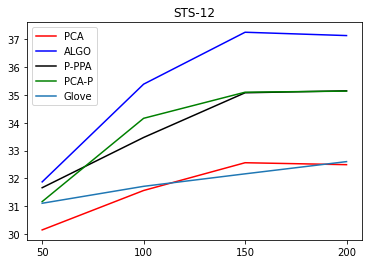

In [49]:
# STS-12
dim = [50, 100, 150, 200]
data = {'PCA':[30.14, 31.56, 32.56, 32.49],
        'ALGO':[31.87, 35.39, 37.26, 37.14],
        'PCA-PPA':[31.66, 33.47, 35.08, 35.15],
        'PPA-PCA':[31.16, 34.16, 35.10, 35.14],
        'Glove':[31.10, 31.71, 32.16, 32.60]}

df = pd.DataFrame(data).T
df.columns = dim
display(df)
plt.title("STS-12")
plt.plot(df.iloc[0], c='r', label='PCA')
plt.plot(df.iloc[1], c='b', label='ALGO')
plt.plot(df.iloc[2], c='k', label='P-PPA')
plt.plot(df.iloc[3], c='g', label='PCA-P')
plt.plot(df.iloc[4], label='Glove')
plt.legend()
plt.xticks(dim)
plt.show()

,50,100,150,200
PCA,26.16,28.58,30.22,30.39
ALGO,34.16,36.95,37.59,39.55
PCA-PPA,27.83,32.26,35.28,35.54
PPA-PCA,29.12,32.81,35.47,35.54
Glove,30.43,29.92,30.33,30.73


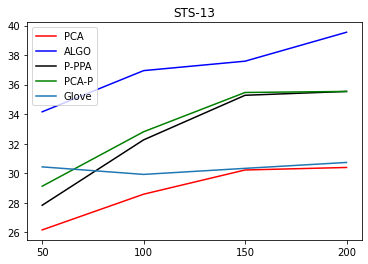

In [51]:
# STS-13
dim = [50, 100, 150, 200]
data = {'PCA':[26.16, 28.58, 30.22, 30.39],
        'ALGO':[34.16, 36.95, 37.59, 39.55],
        'PCA-PPA':[27.83, 32.26, 35.28, 35.54],
        'PPA-PCA':[29.12, 32.81, 35.47, 35.54],
        'Glove':[30.43, 29.92, 30.33, 30.73]}

df = pd.DataFrame(data).T
df.columns = dim
display(df)
plt.title("STS-13")
plt.plot(df.iloc[0], c='r', label='PCA')
plt.plot(df.iloc[1], c='b', label='ALGO')
plt.plot(df.iloc[2], c='k', label='P-PPA')
plt.plot(df.iloc[3], c='g', label='PCA-P')
plt.plot(df.iloc[4], label='Glove')
plt.legend()
plt.xticks(dim)
plt.show()

,50,100,150,200
PCA,33.14,35.14,36.55,36.70
ALGO,41.96,44.48,44.96,45.47
PCA-PPA,37.28,40.92,42.85,42.95
PPA-PCA,38.65,41.29,42.88,42.88
Glove,34.83,35.25,36.09,36.93


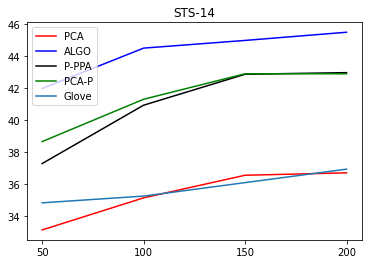

In [52]:
# STS-14
dim = [50, 100, 150, 200]
data = {'PCA':[33.14, 35.14, 36.55, 36.70],
        'ALGO':[41.96, 44.48, 44.96, 45.47],
        'PCA-PPA':[37.28, 40.92, 42.85, 42.95],
        'PPA-PCA':[38.65, 41.29, 42.88, 42.88],
        'Glove':[34.83, 35.25, 36.09, 36.93]}

df = pd.DataFrame(data).T
df.columns = dim
display(df)
plt.title("STS-14")
plt.plot(df.iloc[0], c='r', label='PCA')
plt.plot(df.iloc[1], c='b', label='ALGO')
plt.plot(df.iloc[2], c='k', label='P-PPA')
plt.plot(df.iloc[3], c='g', label='PCA-P')
plt.plot(df.iloc[4], label='Glove')
plt.legend()
plt.xticks(dim)
plt.show()

,50,100,150,200
PCA,34.41,37.58,39.21,39.20
ALGO,41.92,48.16,49.11,49.78
PCA-PPA,39.53,43.88,46.20,46.24
PPA-PCA,39.97,44.04,46.25,46.23
Glove,36.50,37.37,38.33,39.28


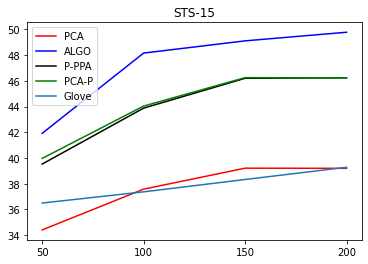

In [53]:
# STS-15
dim = [50, 100, 150, 200]
data = {'PCA':[34.41, 37.58, 39.21, 39.20],
        'ALGO':[41.92, 48.16, 49.11, 49.78],
        'PCA-PPA':[39.53, 43.88, 46.20, 46.24],
        'PPA-PCA':[39.97, 44.04, 46.25, 46.23],
        'Glove':[36.50, 37.37, 38.33, 39.28]}

df = pd.DataFrame(data).T
df.columns = dim
display(df)
plt.title("STS-15")
plt.plot(df.iloc[0], c='r', label='PCA')
plt.plot(df.iloc[1], c='b', label='ALGO')
plt.plot(df.iloc[2], c='k', label='P-PPA')
plt.plot(df.iloc[3], c='g', label='PCA-P')
plt.plot(df.iloc[4], label='Glove')
plt.legend()
plt.xticks(dim)
plt.show()

,50,100,150,200
PCA,30.96,33.22,34.64,34.70
ALGO,37.48,41.25,42.23,42.99
PCA-PPA,34.08,37.63,39.85,39.97
PPA-PCA,34.73,38.08,39.93,39.95
Glove,33.22,33.56,34.23,34.90


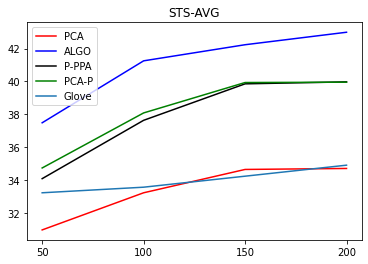

In [54]:
# STS-AVG
dim = [50, 100, 150, 200]
data = {'PCA':[30.96, 33.22, 34.64, 34.70],
        'ALGO':[37.48, 41.25, 42.23, 42.99],
        'PCA-PPA':[34.08, 37.63, 39.85, 39.97],
        'PPA-PCA':[34.73, 38.08, 39.93, 39.95],
        'Glove':[33.22, 33.56, 34.23, 34.90]}

df = pd.DataFrame(data).T
df.columns = dim
display(df)
plt.title("STS-AVG")
plt.plot(df.iloc[0], c='r', label='PCA')
plt.plot(df.iloc[1], c='b', label='ALGO')
plt.plot(df.iloc[2], c='k', label='P-PPA')
plt.plot(df.iloc[3], c='g', label='PCA-P')
plt.plot(df.iloc[4], label='Glove')
plt.legend()
plt.xticks(dim)
plt.show()

### Conclusions 

Empirical results show that **ALGO** method is effective in constructing lower dimensions word embeddings, having similar or (more often) better performance than the original embeddings. This could allow the use of word embeddings in memory-constrained environments.